# Rank Countries Mortality
---

## 00. Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

%matplotlib inline

## 01. Settings

In [3]:
TS_CONFIRMED = "../data/hopkins/time_series-ncov-Confirmed.csv"
TS_DEATHS = "../data/hopkins/time_series-ncov-Deaths.csv"
TS_RECOVERED = "../data/hopkins/time_series-ncov-Recovered.csv"
COLUMN_NAMES = [
    "province_state",
    "country_region",
    "lat",
    "lon",
    "date",
    "value"
]

POPULATION = "../data/word_bank/population_clean.csv"

COUNTRY_MAPPING = {
    'Congo, Dem. Rep.': 'Congo (Kinshasa)',
    'Czech Republic': 'Czechia',
    'Egypt, Arab Rep.': 'Egypt',
    'Guyana': 'French Guiana',
    'Iran, Islamic Rep.': 'Iran',
    'Korea, Rep.': 'Korea, South',
    'Russian Federation': 'Russia',
    'Slovak Republic': 'Slovakia',
    'United States': 'US',
    'Venezuela, RB': 'Venezuela'
}

## 02. Load data

In [4]:
df_confirmed = pd.read_csv(TS_CONFIRMED, skiprows=2, names=COLUMN_NAMES)
df_deaths = pd.read_csv(TS_DEATHS, skiprows=2, names=COLUMN_NAMES)
df_recovered = pd.read_csv(TS_RECOVERED, skiprows=2, names=COLUMN_NAMES)

df_confirmed.rename(columns = {'value':'confirmed'}, inplace = True)
df_deaths.rename(columns = {'value':'deaths'}, inplace = True)
df_recovered.rename(columns = {'value':'recovered'}, inplace = True)

df = df_confirmed
df = df.join(df_deaths[['deaths']])
df = df.join(df_recovered[['recovered']])

In [5]:
df.head()

,province_state,country_region,lat,lon,date,confirmed,deaths,recovered
0,NaN,Afghanistan,33.0,65.0,2020-03-14,11,0,0
1,NaN,Afghanistan,33.0,65.0,2020-03-13,7,0,0
2,NaN,Afghanistan,33.0,65.0,2020-03-12,7,0,0
3,NaN,Afghanistan,33.0,65.0,2020-03-11,7,0,0
4,NaN,Afghanistan,33.0,65.0,2020-03-10,5,0,0


## 03. Mortality per country

In [6]:
date = df['date'].max()
min_confirmed = 5

df_day = df \
    [df['date'] == date] \
    [df['confirmed'] >= min_confirmed] \
    [df['deaths'] > 0] \
    [['country_region', 'confirmed', 'deaths']] \
    .groupby('country_region', as_index=False).sum()

df_day['mortality'] = df_day['deaths'] / df_day['confirmed']
df_day['mortality'].fillna(0.0, inplace=True)
df_day = df_day.sort_values('mortality', ascending=False)

In [7]:
df_day.head()

,country_region,confirmed,deaths,mortality
20,Iraq,110,10,0.090909
1,Algeria,37,3,0.081081
31,Philippines,111,8,0.072072
12,Ecuador,28,2,0.071429
22,Italy,21157,1441,0.068110


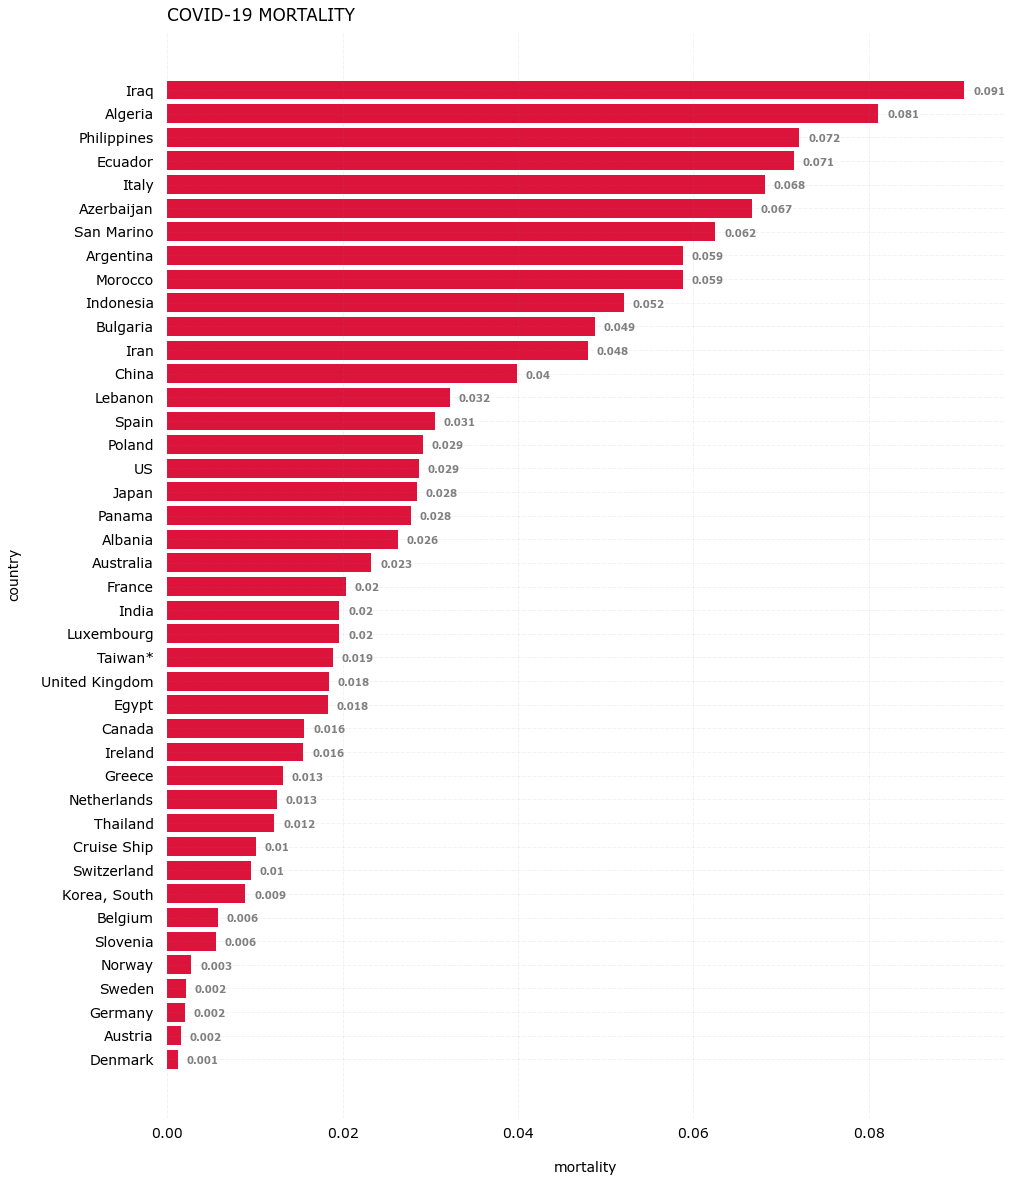

In [8]:
from matplotlib import rcParams

rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Verdana']
rcParams['font.size'] = 14

regions = df_day.iloc[:,0]
mortality = df_day.iloc[:,3]

fig, ax = plt.subplots(figsize=(15,20))
ax.barh(regions, mortality, color='crimson')

for s in ['top','bottom','left','right']:
    ax.spines[s].set_visible(False)

ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

ax.xaxis.set_tick_params(pad=5)
ax.yaxis.set_tick_params(pad=10)

ax.set_xlabel('mortality', labelpad=20)
ax.set_ylabel('country', labelpad=20)

ax.grid(b=True, color='grey', linestyle='-.', linewidth=0.5, alpha=0.2)

ax.invert_yaxis()

ax.set_title('COVID-19 MORTALITY', loc='left', pad=10)

for i in ax.patches:
    ax.text(i.get_width() + 0.001, i.get_y() + 0.6, str(round((i.get_width()), 3)),
            fontsize=10, fontweight='bold', color='grey')

fig.savefig('../viz/mortality.png', dpi=100, bbox_inches='tight')
plt.show()

## 04. Infected percentage of the population

In [9]:
df_population = pd.read_csv(POPULATION)
df_population = df_population[['Country Name', '2018']]
df_population = df_population.replace({'Country Name': COUNTRY_MAPPING})

In [10]:
df_day = df \
    [df['date'] == date] \
    [['country_region', 'confirmed']] \
    .groupby('country_region', as_index=False).sum()

In [11]:
df_day_population = pd.merge(df_day, df_population, left_on='country_region', right_on='Country Name')
df_day_population = df_day_population.drop(['Country Name'], axis=1)
df_day_population.rename(columns = {'2018':'population'}, inplace = True)
df_day_population['infected_per'] = df_day_population['confirmed'] / df_day_population['population'] * 100
df_day_population = df_day_population.sort_values('infected_per', ascending=False)
df_day_population = df_day_population[df_day_population['infected_per'] > 0.001]

In [12]:
df_day_population.head()

,country_region,confirmed,population,infected_per
103,San Marino,80,33785.0,0.236791
55,Iceland,156,353574.0,0.044121
62,Italy,21157,60431283.0,0.035010
90,Norway,1090,5314336.0,0.020511
117,Switzerland,1359,8516543.0,0.015957


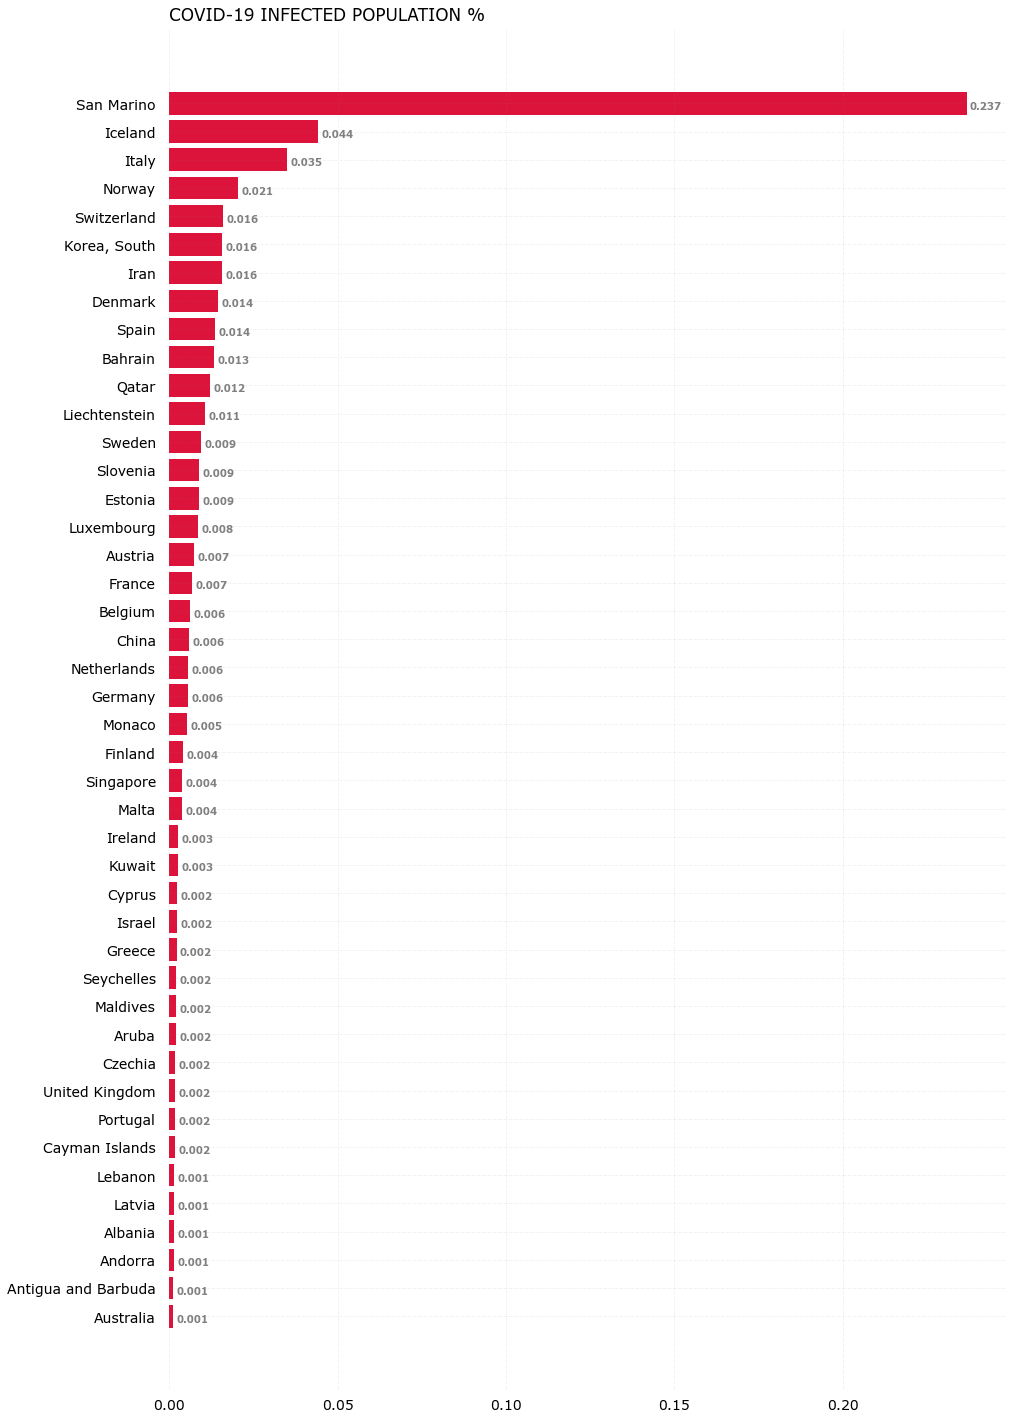

In [13]:
from matplotlib import rcParams

rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Verdana']
rcParams['font.size'] = 14

regions = df_day_population.iloc[:,0]
infected_per = df_day_population.iloc[:,3]

fig, ax = plt.subplots(figsize=(15,25))
ax.barh(regions, infected_per, color='crimson')

for s in ['top','bottom','left','right']:
    ax.spines[s].set_visible(False)

ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

ax.xaxis.set_tick_params(pad=5)
ax.yaxis.set_tick_params(pad=10)

ax.grid(b=True, color='grey', linestyle='-.', linewidth=0.5, alpha=0.2)

ax.invert_yaxis()

ax.set_title('COVID-19 INFECTED POPULATION %', loc='left', pad=10)

for i in ax.patches:
    ax.text(i.get_width() + 0.001, i.get_y() + 0.6, str(round((i.get_width()), 3)),
            fontsize=10, fontweight='bold', color='grey')

fig.savefig('../viz/infected_per.png', dpi=100, bbox_inches='tight')
plt.show()